In [48]:
#!pipenv install opendatasets
#import opendatasets as od #Downloads Kaggle datasets from a notebook
#ruta_kaggle_dataset_1='https://www.kaggle.com/jayrav13/olympic-track-field-results'
#ruta_kaggle_dataset_2='https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results'
#od.download(ruta_kaggle_dataset_1)
#od.download(ruta_kaggle_dataset_2)#Downloads both datasets to the same directory as the notebook

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


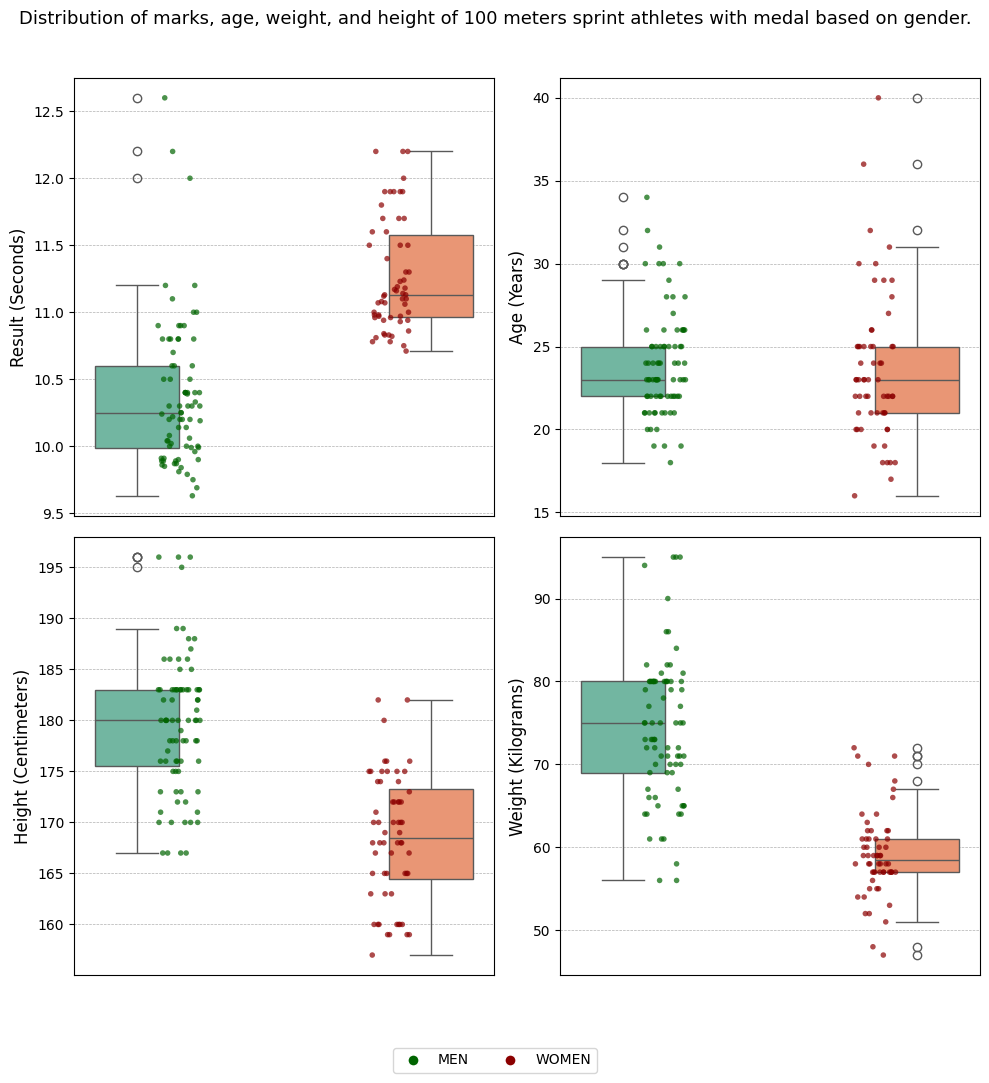

In [62]:
import zipfile as zp # Unzip zip files
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
#--------------------------- Unzipping files ----------------------------
ruta_dir = os.path.dirname(os.path.abspath('assignment4.ipynb')) # Get the path from where the notebook is executed
ruta_data=os.path.join(ruta_dir,"data")
archivos_zip=['olympic_120y_history','olympic_track_field']# List of files to unzip

for i in archivos_zip:
    local_zip = os.path.join(ruta_data, f"{i}.zip")
    with zp.ZipFile(local_zip, 'r') as zipp: 
        zipp.extractall(ruta_data) 
        
#--------------------------- Reading DataFrames from '.csv' files -----------------------------
archivos_csv = [x for x in os.listdir(ruta_data) if x.endswith('.csv')]
df=[] 
for i in archivos_csv: 
    name='df_' + i.replace(".csv","") 
    name=pd.read_csv(os.path.join(ruta_data, i),sep=',',on_bad_lines=lambda x: x[:-1],engine='python')
        # Solves the problem of the 'results' dataframe with commas in the final column of 9 records causing an error
    df.append(name)

#-------------------- Reading DataFrame from '.json' file ----------------------
df_results_json=pd.read_json(os.path.join(ruta_data, 'results.json'))

# We have 4 DataFrames in memory: df_results_json; and those extracted in the for loop saved in the df list:
# df_results; df[0] = df_athlete_events; df[1]= df_noc_regions; df[2]= df_results
df_eventos=df[0].copy()
df_regions=df[1].copy()
df_results_csv=df[2].copy()
df_eventos_100=df_eventos.copy()
# Preparing the 'Medal' column (put 1 where there is a medal and 0 otherwise)
df_eventos_100['Medal']=df_eventos_100['Medal'].map({'Gold':'G','Silver':'S','Bronze':'B',np.nan:0},na_action=None)
df_eventos_100['Sex']=df_eventos_100['Sex'].map({'M':'M','F':'W',np.nan:0},na_action=None)
# Only athletes in 100m sprint with a medal (those with a result in the 'results' table)
filtro=((df_eventos_100['Event']=="Athletics Men's 100 metres")|
        (df_eventos_100['Event']=="Athletics Women's 100 metres")) & (df_eventos_100['Medal']!=0)
df_100m=df_eventos_100[filtro]
#print(atletas) #df_100m 127 atletas & 151 medallas & 151 eventos 100M lisos
filtro2=(df_results_csv['Event']=="100M Women")|(df_results_csv['Event']=="100M Men")
df_100m_mark=df_results_csv[filtro2]
#print(len(atletas2))#df_100m_mark  122 atletas & 142 medallas % 142 eventos
campo_comun=[]
for fila in df_100m.values:
    token=f'{fila[9]}{fila[2]}{fila[14]}'
    campo_comun.append(token)   
df_100m['campo_comun']=campo_comun

campo_comun2=[]
for fila in df_100m_mark.values:
    token=f'{fila[3]}{fila[0]}{fila[4]}'
    campo_comun2.append(token)   
df_100m_mark['campo_comun']=campo_comun2
#----------------------------------------------------------------------------------------------
# Combine the datasets:
combined_dataset = df_100m_mark.merge(df_100m, on='campo_comun', how='inner') # parametro 'on' define la columna pivote
# Mark erroneous records for removal:
def marca_impostores(name1,name2):
    '''
    Function that detects if the name of an athletes DF is the same as that of the results DF.
    Input: name1 (str) and name2 (str)
    Output: bool
    From the two provided strings, it slices the first one in such a way that
    it obtains the name and a portion of the surname in lowercase. If either of these two slices
    is within the name2 string, it implies that it is the same person, so it modifies 
    the impostor boolean to False
    '''
    impostor=True
    ind = name1.index(" ")
    apellido=(name1[ind:ind+5]).lower()
    nombre=(name1[:ind]).lower()
    cadena=name2.lower()
    if (nombre in cadena) | (apellido in cadena):
        impostor=False
    return impostor
    
impostor=[]
contador2=0
for fila in combined_dataset.values:
    contador2+=1
    distinto=marca_impostores(fila[5],fila[10])
    impostor.append(distinto)
    
combined_dataset['Impostor']=impostor
# Remove erroneous rows:
impostores_df_indx=combined_dataset[combined_dataset['Impostor']==True].index
df_resultados=combined_dataset.drop(impostores_df_indx)
# Remove columns not used:
sobra=['Event_x','Name_x','Location','Name_y','Year_x','Medal_x','Nationality','campo_comun','ID','Sex','Team','NOC','Games','Year_y','Season','City','Sport','Event_y','Medal_y','Impostor']
df_resultados.drop(sobra,axis=1,inplace=True)
# Remove rows without a value in time:
nulos_df_indx=df_resultados[df_resultados['Result']=='None'].index
df_resultados=df_resultados.drop(nulos_df_indx)
df_resultados = df_resultados[df_resultados['Weight'].notna()]#eliminar nulos en weight
df_resultados['Result'] = df_resultados['Result'].astype(float)#convertir resultado en float
df_copia=df_resultados.copy()
#------------------Get the data-------------------------------------------------------
df_mean=df_copia.groupby(by='Gender').mean().sort_index(ascending=False)#medias de cada parametro
df_copia['Gender'] = df_copia['Gender'].replace({'M': 'MEN', 'W': 'WOMEN'})
parametros=list(df_copia.columns)
del parametros[0] # Remove 'Gender'

# Get the means of each parameter based on the category
means_parametros=[]
for _i in parametros:
    mean_parametro=f'mean_{_i}'
    mean_parametro=df_mean[_i]
    means_parametros.append(list(mean_parametro)) 
categorias=list(df_mean.index)# Categories are the indices of the 'groupby'

#------------------Represent the data---------------------------

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Reduje la anchura de la figura

fig.suptitle('Distribution of marks, age, weight, and height of 100 meters sprint athletes with medal based on gender.', fontsize=13,ha='center')

y_labels=['Seconds','Years','Centimeters','Kilograms']
for i, (parametro, ax) in enumerate(zip(parametros, axes.flatten())):
    sns.boxplot(x='Gender', y=parametro, data=df_copia, ax=ax,  palette="Set2",hue='Gender', dodge=True)
    sns.stripplot(x='Gender', y=parametro, data=df_copia, ax=ax, hue='Gender', palette={'MEN': 'darkgreen', 'WOMEN': 'darkred'}, marker='o', size=4, alpha=0.7, jitter=True)
    #ax.set_title(f'{parametro}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel(f'{parametro} ({y_labels[i]})', fontsize=12)
    ax.grid(which='major', axis='y', linestyle='--', linewidth=0.5)
    ax.legend().set_visible(False)
    ax.set_xticks([]) 
    ax.set_xticklabels([]) 

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=8),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8)]
labels = ['MEN', 'WOMEN']

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.09), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('assignment4.png', dpi=300, bbox_inches='tight')
plt.show()